In [1]:
import json
import os
import urllib.request as request

def download_and_load_file(file_path: str, url: str):
    """下载，并加载指令微调数据集

    Args:
        file_path (str): 文件地址
        url (str): URL
    """
    if not os.path.exists(file_path):
        with request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, 'w', encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, 'r', encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data = download_and_load_file(file_path="instruction-data.json", url=(
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
))

In [2]:
def format_input(entry: dict[str, str]) -> str:
    """格式化输入

    Args:
        entry (dict[str, str]): 输入字典（JSON）

    Returns:
        str: 格式化指令微调数据
    """
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (f"\n\n### Input:\n{entry['input']}" if entry['input'] else "")
    return instruction_text + input_text
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
model_input + desired_response

"Below is an instruction that describes a task.Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion\n\n### Response:\nThe correct spelling is 'Occasion.'"

In [3]:
# 划分数据集
train_portion = int(len(data) * 0.85) # 使用85%的数据集作为训练集
test_portion = int(len(data) * 0.1)   # 使用10%的数据集作为测试集
val_portion = len(data) - train_portion - test_portion # 使用剩余（5%）数据集作为验证集

# 通过切片索引划分数据集
train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion + test_portion:]

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from tiktoken.core import Encoding

class InstructionDataset(Dataset):
    """创建指令微调数据集

    Args:
        Dataset (Dataset): PyTorch Dataset
    """
    def __init__(self, data: list[dict[str, str]], tokenizer: Encoding) -> None:
        """创建指令微调数据集

        Args:
            data (list[dict[str, str]]): 原始指令数据
            tokenizer (Encoding): 分词器
        """
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry=entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
        
    def __getitem__(self, index: int):
        return self.encoded_texts[index]

    def __len__(self) -> int:
        return len(self.data)

In [5]:
def custom_collate_draft(batch: Dataset, pad_token_id: int=50256, ignore_index: int=-100, allowed_max_length: int=None, device: str="cuda") -> tuple[torch.Tensor, torch.Tensor]:
    """数据集聚合函数

    Args:
        batch (Dataset): 批次
        pad_token_id (int, optional): Padding Token ID. Defaults to 50256.
        ignore_index (int, optional): 掩码ID. Defaults to -100.
        allowed_max_length (int, optional): 允许序列的最大长度. Defaults to None.
        device (str, optional): 变量存储设备. Defaults to "cuda".

    Returns:
        tuple[torch.Tensor, torch.Tensor]: 输入和目标
    """
    batch_max_length = max(len(item)+1 for item in batch) # 找到批次最长的序列
    inputs_list, target_list = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        
        inputs  = torch.tensor(padded[:-1]) # 删除之前添加的额外填充词元
        targets = torch.tensor(padded[1:])  # 因为已经添加了额外一个词元，因此直接从index=1处开始切片即可
        
        # 将目标序列中除第一个填充词元外的所有填充词元都替换为ignore_index
        mask = targets == pad_token_id # 设置mask为boolean张量（向量），形状与targtes一致，比较pad_token_id，等于pad_token_id的为true
        indices = torch.nonzero(mask).squeeze() # 但torch.nonzero返回格式会包含多个维度，继续使用squeeze将1轴去除，得到展平为一个维度的张量
        if indices.numel() > 1:
            # 随后大于1的表示包含不止一个pad_token_id的序列，将末尾1个pad_token_id之后的pad_token_id全部设置为ignore_index即可
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            # 根据allowed_max_length截断输入和目标到允许的最大长度即可
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_list.append(inputs)
        target_list.append(targets)
        
    inputs_tensor = torch.stack(inputs_list).to(device) # 输入列表变成一个张量，并转移到目标设备
    target_tensor = torch.stack(target_list).to(device)
    return inputs_tensor, target_tensor

inputs1 = [0, 1, 2, 3, 4]
inputs2 = [5, 6]
inputs3 = [7, 8, 9]
batch = (inputs1, inputs2, inputs3)
inputs_tensor, target_tensor = custom_collate_draft(batch=batch)
inputs_tensor, target_tensor

(tensor([[    0,     1,     2,     3,     4],
         [    5,     6, 50256, 50256, 50256],
         [    7,     8,     9, 50256, 50256]], device='cuda:0'),
 tensor([[    1,     2,     3,     4, 50256],
         [    6, 50256,  -100,  -100,  -100],
         [    8,     9, 50256,  -100,  -100]], device='cuda:0'))

In [6]:
# 创建数据集加载器
from functools import partial
import tiktoken
import torch.nn as nn

tokenizer = tiktoken.get_encoding("gpt2")

custom_collate_fn = partial(
    custom_collate_draft,
    device="cuda",
    allowed_max_length=1024
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(data=train_data, tokenizer=tokenizer)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

val_dataset = InstructionDataset(data=val_data, tokenizer=tokenizer)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

test_dataset = InstructionDataset(data=test_data, tokenizer=tokenizer)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

emb = nn.Embedding(50257, 768, device="cuda")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    print(emb(inputs).shape)
    break

torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 61, 768])


In [7]:
from gpt_download import download_and_load_gpt2
from GPTModel import GPTModel2, load_weights_into_gpt

BASE_CONFIG = {
    'vocab_size': 50257,    # 词汇表大小
    'context_length': 1024, # 上下文维度
    'drop_rate': 0.0,       # Dropout 率
    'qkv_bias': True        # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)":  {"emb_dim": 768,  "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)":  {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)":    {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

setttings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel2(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2026-01-29 15:10:06.561295: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-29 15:10:06.640348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-29 15:10:08.673025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Output text:
 Hello there you two – I think it's too early to draw any specific conclusions or conclusions about where Trump may be taking you.

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File a

GPTModel2(
  (token_embeddings): Embedding(50257, 1024)
  (position_embeddings): Embedding(1024, 1024)
  (dropout_embeddings): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (pre_layer_norm): LayerNorm()
      (post_layer_nrom): LayerNorm()
      (multi_head_attention): MultiHeadAttention(
        (query_layer): Linear(in_features=1024, out_features=1024, bias=True)
        (key_layer): Linear(in_features=1024, out_features=1024, bias=True)
        (value_layer): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_layer): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (feed_forward): FeedForwardLayer(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
   

In [8]:
# 基准评估
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [9]:
# 使用generate函数生成模型的回复
from GPTModel import generate, text_to_token_ids, token_ids_to_text
token_ids = generate(
    model=model.to("cuda"),
    idx=text_to_token_ids(text=input_text, tokenizer=tokenizer).to("cuda"),
    context_size=BASE_CONFIG['context_length'],
    max_new_tokens=35,
    eos_id=50256
)
generate_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
generate_text

"Below is an instruction that describes a task.Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Instruction:\n\nConvert the active"

In [10]:
response_text = generate_text[len(input_text):].strip()
response_text

"### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Instruction:\n\nConvert the active"

In [12]:
from pre_training import calc_loss_loader, train_model_simple, plot_losses
torch.manual_seed(123)
# 首先计算模型在训练集和验证集上的初始损失
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, "cuda", num_batchs=5)
    val_loss = calc_loss_loader(val_loader, model, "cuda", num_batchs=5)
print(f"Training Loss:{train_loss}")
print(f"Validation Loss:{val_loss}")

Training Loss:4.013571500778198
Validation Loss:3.9755326747894286


In [14]:
# 执行训练
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, token_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    valid_loader=val_loader,
    optimizer=optimizer,
    device="cuda",
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5
)

Ep 1 (Step 000000)Train Loss 2.835Valid Loss 2.830
Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.  ### Instruction: Write a response that appropriately completes the request.  ### Response: The chef cooks the meal every day.  ### Instruction: Write
Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day
Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to 

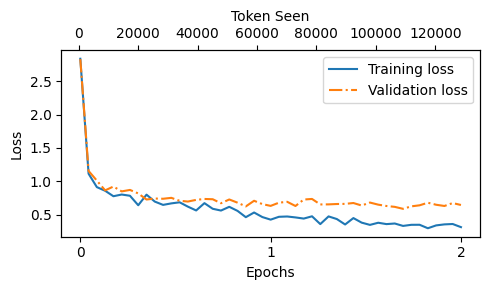

In [15]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen=token_seen, train_losses=train_losses, val_losse=val_losses)

In [16]:
# 保存模型参数
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)